Predict Long, Short or Stable position based on some indicators computed from historical price values.
Based on https://arxiv.org/abs/1706.10059

- State :Closing Prices in a given window
- Action : Pick Short, Long or Stable position
- Reward : (pt/pt-1 - 1)*position

shortfalls:
- Geometric distribution for batch sampling
- No temporal modeling (TODO)
- Memory (TODO)
- No portfolia management (TODO)

Problems:
- Model converges zero with all the predictions

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
np.random.seed(1335)  # for reproducibility
# np.set_printoptions(precision=5, suppress=True, linewidth=150)
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import finance as fin
from reinforcement_learning.utils9 import *

DATA_PATH = "../data/bitcoin-historical-data/coinbaseUSD_1-min_data_2014-12-01_to_2017-10-20.csv.csv"
TIME_GRAN = 30  # time granularity in minutes
TEST_DAYS = 50  # num prediction days for the trained models
TEST_START = ((24*60) / TIME_GRAN) * TEST_DAYS 
TRAIN_DAYS = 2 * 365  # train on the past 2 years
TRAIN_START = ((24*60) / TIME_GRAN) * TRAIN_DAYS  # take only afterwards
NUM_OUTPUTS = 2
NUM_FEATS = 50
NUM_ACTIONS = 3

df = read_data(DATA_PATH, TIME_GRAN)
df_test = df.iloc[df.shape[0]-TEST_START:,]
df_train = df.iloc[df.shape[0]-TEST_START-TRAIN_START:df.shape[0]-TEST_START,] 
print(df_train.shape)
print(df_test.shape)

/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The finance module has been deprecated in mpl 2.0 and will be removed in mpl 2.2. Please use the module mpl_finance instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.
 > There are 48636 rows
(35040, 4)
(2400, 4)


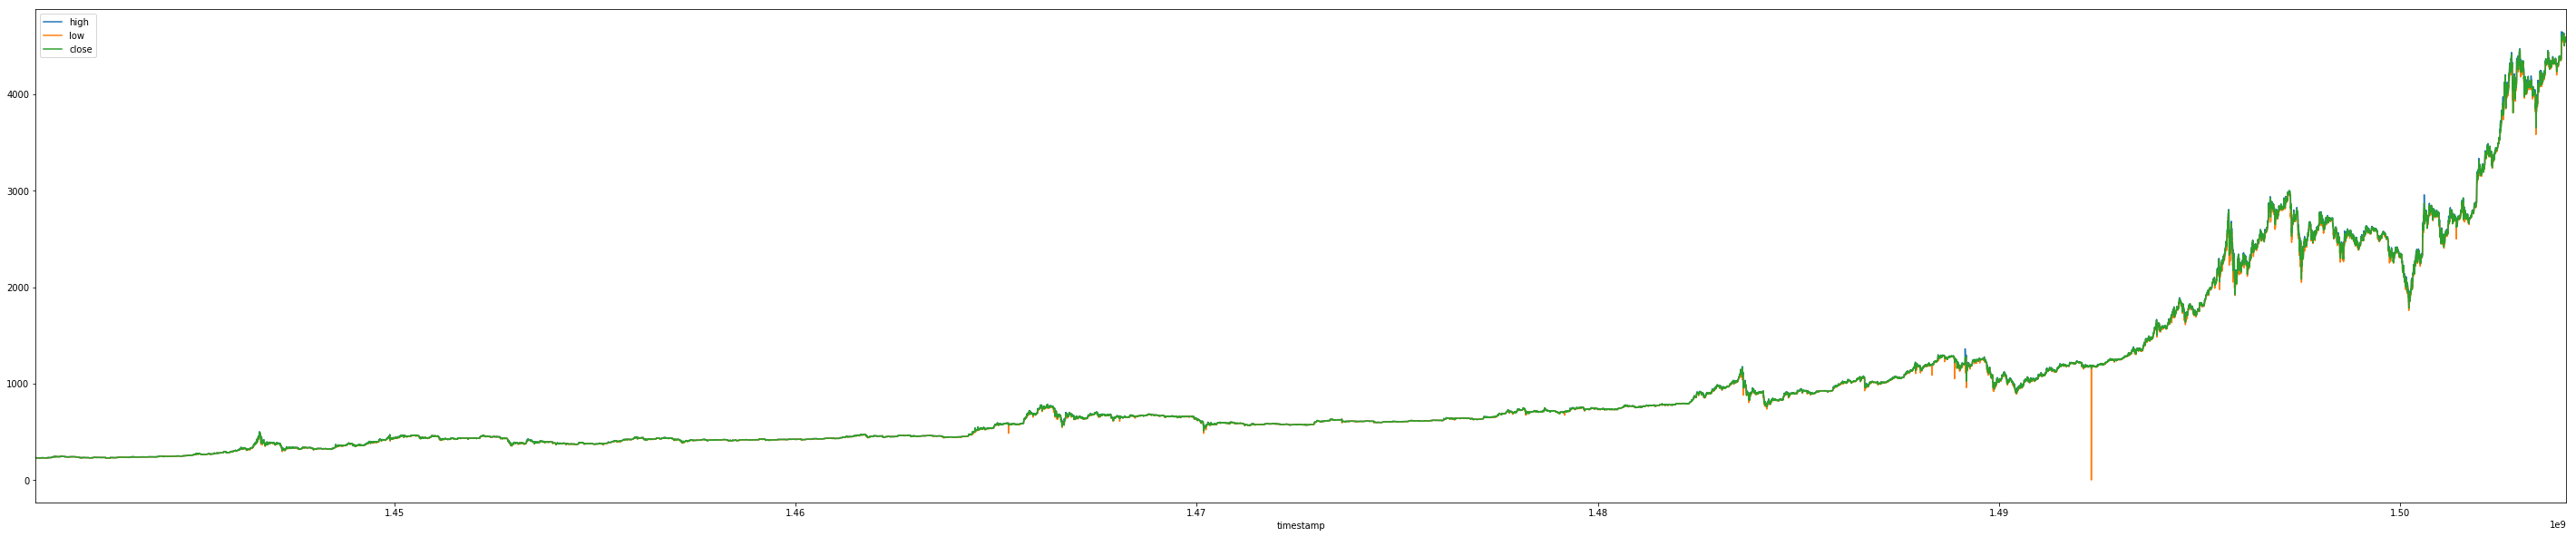

In [2]:
df_train.plot(x='timestamp', figsize=(50, 10))

In [2]:
import timeit

start_time = timeit.default_timer()

# set train and test data
train_data = df_train
test_data = df_test
start_timestep = 0

# # create model
model = create_model(NUM_ACTIONS, NUM_FEATS)

# training arguments
epochs = 250
batch_size = 50
gamma = 0
epsilon = 0  # parameter setting initial random actions, that decays as learning 
beta = 5e-5

# stores tuples of (S, A, R, S')
signal = pd.Series(index=np.arange(len(train_data)), data=[None]*len(train_data))

# replay memory
replay_memory = ReplayMemory(5000)

# create states
train_states, train_prices = create_states(df_train, NUM_FEATS)
test_states, test_prices = create_states(df_test, NUM_FEATS)

# let the agent learn
learning_progress = []
sim_count = 0
for i in range(epochs):
    avg_sim_reward = AverageMeter()
    terminal_state = 0
    
    time_step = np.random.geometric(beta) # sample start point with geometrical
    while time_step >= train_states.shape[0]:
        time_step = np.random.geometric(beta)
    
    state = train_states[time_step][None, :]
        
    #while game still in progress
    while(terminal_state == 0):
        
        # We are in state S
        # 1- Compute the next action based on state S with the network
        if (random.random() < epsilon): #choose random action
            action = np.random.randint(0,NUM_ACTIONS) #assumes 4 different actions
        else: #choose best action from Q(s,a) values
            qval = model.predict(state, batch_size=1)
            action = qval[0][0]
            
        # 2- Take action, observe new state S'
        new_state, new_time_step, signal, terminal_state = take_action(train_states,
                                                                       action,
                                                                       signal,
                                                                       time_step)
        assert new_time_step - time_step == 1
       
        # 3- Compute the reward
        reward = get_reward(time_step, train_prices, signal, eval=False)
#         print(" Action: {}, Signal: {}, Reward: {} Price: {} TimeStep: {}".format(action, 
#                                                                                   signal[time_step],
#                                                                                   reward,
#                                                                                   train_prices[time_step],
#                                                                                   time_step))        
        # Update average simulation reward
        avg_sim_reward.update(reward)
       
        # Add new experience to replay memory
        replay_memory.push(state, action, new_state, reward)
        
        # Experience replay storage, if we add enough new experiences
        optimize_DQN(model, replay_memory, batch_size, gamma)
        
        # One step ahead
        state = new_state
        time_step = new_time_step
        assert (train_states[new_time_step] - new_state).sum() == 0
        
    # eval model on test data
    test_reward = evaluate_Q(test_states, test_prices, model, get_reward)
#     print(action_count)
    # learning_progress.append((eval_reward))
    learning_progress.append(avg_sim_reward.avg)
    print("Epoch #: %s SimReward: %f Epsilon: %f TestReward: %f" % (i, avg_sim_reward.avg, epsilon, test_reward))
    
    # reward stats
    print(" > Reward stats ...")
    values = [r[-1] for r in replay_memory.memory]
    values = pd.Series(values)
    print(values.describe())
    
    # action stats
    print(" > Action stats ...")
    values = [r[1] for r in replay_memory.memory]
    values = pd.Series(values)
    print(values.describe())
    
    # decay epsilon
    if epsilon > 0.1: #decrement epsilon over time
        epsilon -= (1.0/epochs)

elapsed = np.round(timeit.default_timer() - start_time, decimals=2)
print("Completed in %f" % (elapsed,))

Epoch #: 0 SimReward: 0.002407 Epsilon: 0.000000 TestReward: 0.000430
 > Reward stats ...
count    5000.000000
mean        0.001363
std         0.042538
min        -0.766342
25%        -0.009704
50%         0.000950
75%         0.012822
max         0.807004
dtype: float64
 > Action stats ...
count    5000.000000
mean        0.037538
std         0.018573
min         0.003036
25%         0.024171
50%         0.035046
75%         0.047110
max         0.128220
dtype: float64
Epoch #: 1 SimReward: 0.000137 Epsilon: 0.000000 TestReward: 0.000316
 > Reward stats ...
count    5000.000000
mean        0.000241
std         0.006234
min        -0.068784
25%        -0.000080
50%         0.000005
75%         0.000110
max         0.264794
dtype: float64
 > Action stats ...
count    5.000000e+03
mean     6.773111e-04
std      2.026222e-03
min      7.568638e-08
25%      1.575122e-04
50%      3.219463e-04
75%      5.995559e-04
max      5.888262e-02
dtype: float64
Epoch #: 2 SimReward: 0.000321 Epsilon: 

KeyboardInterrupt: 

In [ ]:
# plt.figure(figsize=[20, 40])
# plt.subplot(3,1,1)
# bt.plotTrades()

# plt.subplot(3,1,2)
# bt.pnl.plot(style='x-')

plt.subplot(3,1,3)
plt.plot(learning_progress)

plt.savefig('reinforcement_learning/plt/summary'+'.png', bbox_inches='tight', pad_inches=1, dpi=72)
# plt.show()